In [7]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

from holotomocupy.holo import G
from holotomocupy.shift import S
from holotomocupy.utils import *

%matplotlib inline

np.random.seed(10)

# Init data sizes and parametes of the PXM of ID16A

In [8]:
n = 2048  # object size in each dimension
pad = n//8

6
[-1246. -1342.]
[-1263.  -737.]
[-1281.  -292.]
[-1319.   289.]
[-1323.   715.]
[-1257.  1338.]
[ -832. -1279.]
[-728. -754.]
[-740. -283.]
[-715.  283.]
[-763.  722.]
[-785. 1302.]
[ -264. -1289.]
[-241. -767.]
[-237. -244.]
[-217.  258.]
[-204.  744.]
[-309. 1254.]
[  206. -1238.]
[ 198. -752.]
[ 262. -216.]
[217. 301.]
[237. 800.]
[ 229. 1329.]
[  745. -1323.]
[ 754. -821.]
[ 809. -301.]
[753. 312.]
[830. 762.]
[ 809. 1248.]
[ 1292. -1229.]
[1284. -757.]
[1221. -275.]
[1226.  231.]
[1258.  803.]
[1221. 1270.]
parameters for recon:
size 4608
npos 36


/tmp/ipykernel_988421/1963979392.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


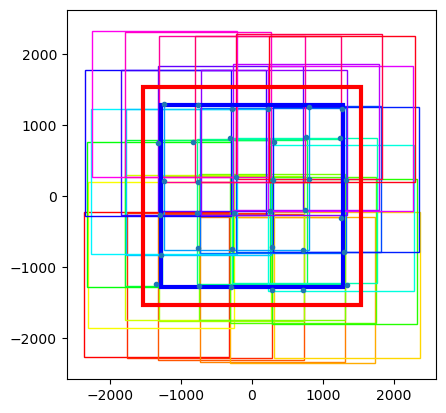

In [9]:
import matplotlib.patches as patches
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

fig, ax = plt.subplots()

step = n//4
s = 5*n//4 # size without pad

npos0 = int(np.ceil((s+2*pad)/step))
print(npos0)
cmap = get_cmap(npos0**2)
shifts_code = np.zeros([1,npos0**2,2],dtype='float32')
ipos = 0
for y in range(npos0):
    for x in range(npos0): 
        for k in range(1):       
            shifts_code[0,ipos,0] = int((y-npos0/2+0.5)*step+(np.random.random(1)[0]-0.5)*n//16)
            shifts_code[0,ipos,1] = int((x-npos0/2+0.5)*step+(np.random.random(1)[0]-0.5)*n//16)
            ipos+=1
for k in range(npos0**2):
    for j in range(1):
        print(shifts_code[0,k*1+j,:])
        rect = patches.Rectangle((shifts_code[0,k*1+j,1]-n//2, shifts_code[0,k*1+j,0]-n//2), n, n, linewidth=1, edgecolor=cmap(k), facecolor='none')        
        ax.add_patch(rect)

ax.plot(shifts_code[0,:,1],shifts_code[0,:,0],'.',)

ax.axis('square')
rect = patches.Rectangle((0-s//2-pad, 0-s//2-pad), s+2*pad, s+2*pad, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)

ax.axis('square')
rect = patches.Rectangle((0-n//2-pad, 0-n//2-pad), n+2*pad, n+2*pad, linewidth=3, edgecolor='b', facecolor='none')
ax.add_patch(rect)



print("parameters for recon:")
print("size",n+(npos0-1)*step)
npos = npos0**2
print("npos",npos)




In [10]:

z1c = -19.5e-3
# thickness of the coded aperture
code_thickness = 1.8e-6 #in m
# feature size
ill_feature_size = 2e-6 #in m

detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = z1c
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size

# sample size after demagnification
ne = n+2*pad
nee = n+(npos0-1)*step+pad # extra pad due to random shift
show = True

flg = f'{n}_{z1c}'
path = f'/data2/vnikitin/nfp_codes'
print(voxelsize)

4.570312499999999e-08


## Load probe, note run make_probe first

In [11]:
prb_abs = read_tiff(f'{flg}/prb_abs_2048_code.tiff')[0:1]
prb_phase = read_tiff(f'{flg}/prb_phase_2048_code.tiff')[0:1]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')
for k in range(int(np.log2(2048//n))):
    prb = 0.5*(prb[:,::2,:]+prb[:,1::2,:])
    prb = 0.5*(prb[:,:,::2]+prb[:,:,1::2])
prb /= np.mean(np.abs(prb))
prb.shape

(1, 2560, 2560)

### Generate a coded aperture, make it twice bigger than the sample to allow motion

1.1906916589949026e-07 2.863698115973534e-06 24.050711150449015


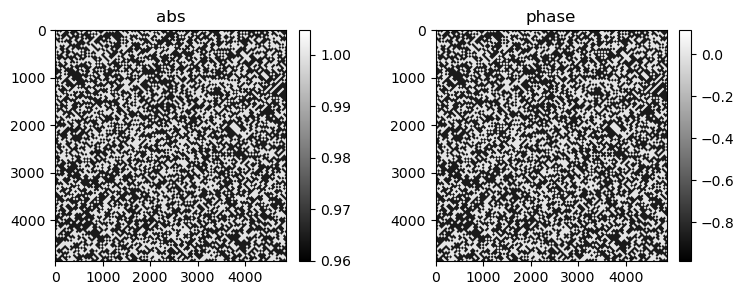

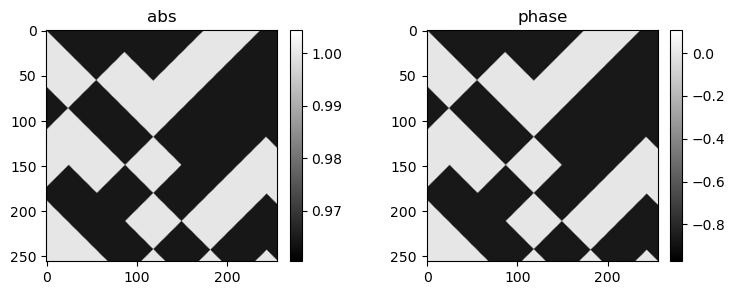

In [12]:
import cupy.random as random
import xraylib
import cupyx.scipy.ndimage as ndimage



random.seed(10)
nill = nee
ill_global = cp.zeros([1,nill,nill],dtype='bool')
for k in  range(ill_global.shape[0]):
    ill0 = cp.zeros([nill*nill],dtype='bool')
    ill_ids = cp.random.choice(cp.arange(0, nill*nill), int(nill*nill*0.55),replace=False)
    ill0[ill_ids] = 1
    ill_global[k] = ill0.reshape(nill,nill)
# form codes for simulations
nill = int(nee*voxelsize//(ill_feature_size*2))*2
ill = cp.zeros([1,nill,nill],dtype='bool')
for k in  range(ill.shape[0]):
    ill0 = ill_global[k]
    ill[k] = ill0[ill0.shape[0]//2-nill//2:ill0.shape[0]//2+(nill)//2,ill0.shape[1]//2-nill//2:ill0.shape[1]//2+(nill)//2]#.reshape(nill,nill)
ill = cp.array(ill)    
ill = ndimage.zoom(ill,[1,nee/nill,nee/nill],order=0,grid_mode=True,mode='grid-wrap')



delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)
print(beta,delta,delta/beta)
thickness = code_thickness/voxelsize # thickness in pixels
# form Transmittance function

Rill = ill*(-delta+1j*beta)*thickness 
Rill=ndimage.rotate(Rill, 45, axes=(2, 1), reshape=False, order=3, mode='reflect',
                   prefilter=True)

v = cp.arange(-nee//2,nee//2)/2/ne
[vx,vy] = cp.meshgrid(v,v)
v = cp.exp(-2*(vx**2+vy**2))
fill = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(Rill)))
Rill = cp.fft.fftshift(cp.fft.ifftn(cp.fft.fftshift(fill*v)))
Rill = Rill.astype('complex64')

code = cp.exp(1j * Rill * voxelsize * 2 * np.pi / wavelength).astype('complex64')
code = code.get()

mshow_polar(code[0],show)

mshow_polar(code[0,:n//8,:n//8],show)



In [13]:
print('voxelsize',voxelsize)
print('field of view',voxelsize*n)
print('detector voxel size after binning', voxelsize*magnifications[0])
print('detector field of view', voxelsize*n*magnifications[0])
print(45*voxelsize)

voxelsize 4.570312499999999e-08
field of view 9.359999999999998e-05
detector voxel size after binning -3e-06
detector field of view -0.006144
2.056640625e-06


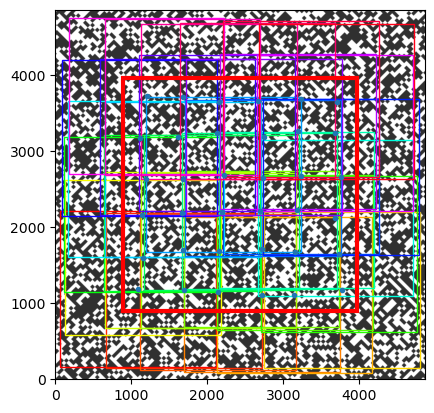

In [14]:

fig, ax = plt.subplots()
ax.imshow(code[0].real,cmap='gray')
#ax.set(xticks=np.arange(-code.shape[1]//2,code.shape[1]//2,100))
for k in range(npos0**2):
    for j in range(1):
        rect = patches.Rectangle((shifts_code[0,k*1+j,1]-n//2+code.shape[1]//2, shifts_code[0,k*1+j,0]-n//2+code.shape[1]//2), n, n, linewidth=1, edgecolor=cmap(k), facecolor='none')
        ax.add_patch(rect)


ax.axis('square')
ax.plot(shifts_code[0,:,1]+code.shape[1]//2,shifts_code[0,:,0]+code.shape[1]//2,'.',)
# print(s)
ax.axis('square')
rect = patches.Rectangle((0-s//2-pad+code.shape[1]//2, 0-s//2-pad+code.shape[1]//2), s+2*pad, s+2*pad, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

### Compute holographic projections for all positions

In [15]:
def _fwd_holo(psi, shifts_code, prb):
    prb = cp.array(prb)
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
        prbr = cp.tile(prb, [psi.shape[0], 1, 1])
        
        # shift and crop the code 
        psir = S(psir, shifts_code[:, i])
        nee = psir.shape[1]
        psir = psir[:, nee//2-n//2-pad:nee/2+n//2+pad, nee//2-n//2-pad:nee/2+n//2+pad]
        psir *= prbr
        
        # propagate the code to the probe plane
        psir = G(psir, wavelength, voxelsize, distances[i])
        
        # unpad
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code,  prb)

def _fwd_holo0(prb):    
    data = cp.zeros([1,npos, n, n], dtype='complex64')
    for j in range(npos):
        # propagate illumination 
        data[:,j] = G(prb, wavelength, voxelsize, distances[0])[:,pad:n+pad,pad:n+pad]        
    return data

def fwd_holo0(prb): 
    return _fwd_holo0(prb)

# Apply the forward transform
psi = cp.array(code)
prb = cp.array(prb)
shifts_code = cp.array(shifts_code)
fpsi = fwd_holo(psi, prb)
fref = fwd_holo0(prb)

### Take squared absolute value to simulate data on the detector

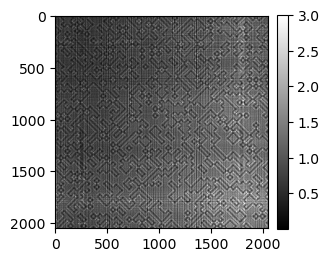

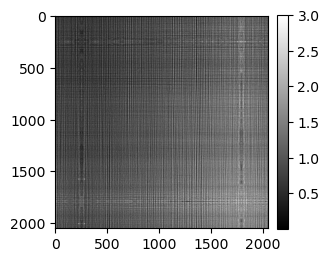

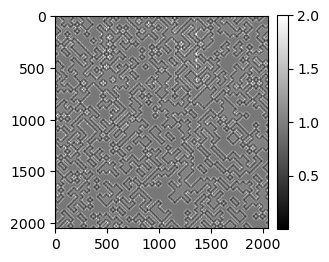

In [16]:
data = np.abs(fpsi)**2
ref = np.abs(fref)**2
mshow(data[0,0],show,vmax=3)
mshow(ref[0,0],show,vmax=3)
mshow(data[0,0]/ref[0,0],show,vmax=2)


### Save data and shifts

In [17]:
for k in range(npos):
    write_tiff(data[:,k],f'{path}/data_{k}_{flg}')
for k in range(npos):
    write_tiff(ref[:,k],f'{path}/ref_{k}_{flg}')

np.save(f'{path}/code_{flg}',code)
np.save(f'{path}/shifts_code_nfp_{flg}', shifts_code)
np.save(f'{path}/prb_{flg}', prb)
np.save(f'{path}/psi_{flg}', psi)
print(f'{path}/data_{k}_{flg}.tiff')



/data2/vnikitin/nfp_codes/data_35_2048_-0.0195.tiff
